In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

### Load good hyperparameters

In [ ]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
tau = float(params['tau'][i])
mixtures = int(params['mixtures'][i])
temp = float(params['temp'][i])
model_name = 'LeNet_300_100'
data_size = 'search'

### Override Parameters

In [ ]:
mixtures = 15
temp = 4
#mean = 10


###calc alpha/beta
beta = mean/var
alpha = mean * beta

### Simple SWS

In [5]:
model_sws, gmp_sws = retrain_model(alpha, beta, tau, int(0), mixtures, model_name, data_size, "", False)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.10343045555032249
Epoch: 10. Test Accuracy: 98.07
Epoch: 20. Test Accuracy: 97.97
Epoch: 30. Test Accuracy: 96.93
Epoch: 40. Test Accuracy: 96.48
Epoch: 50. Test Accuracy: 96.31
Retrain Test: 96.31, Retrain Validation: 96.49, Prune Test: 94.16, Prune Validation: 94.38, Prune Sparsity: 98.53


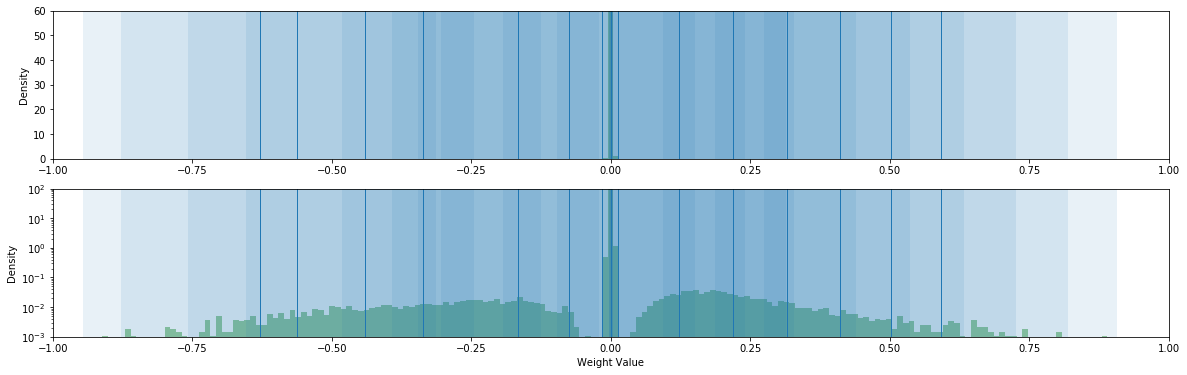

In [6]:
show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))

### KD

In [7]:
model_kd, gmp_kd = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", False)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.10343045555032249
Epoch: 10. Test Accuracy: 97.95
Epoch: 20. Test Accuracy: 97.65
Epoch: 30. Test Accuracy: 97.34
Epoch: 40. Test Accuracy: 96.68
Epoch: 50. Test Accuracy: 96.81
Retrain Test: 96.81, Retrain Validation: 96.54, Prune Test: 94.71, Prune Validation: 94.37, Prune Sparsity: 98.03


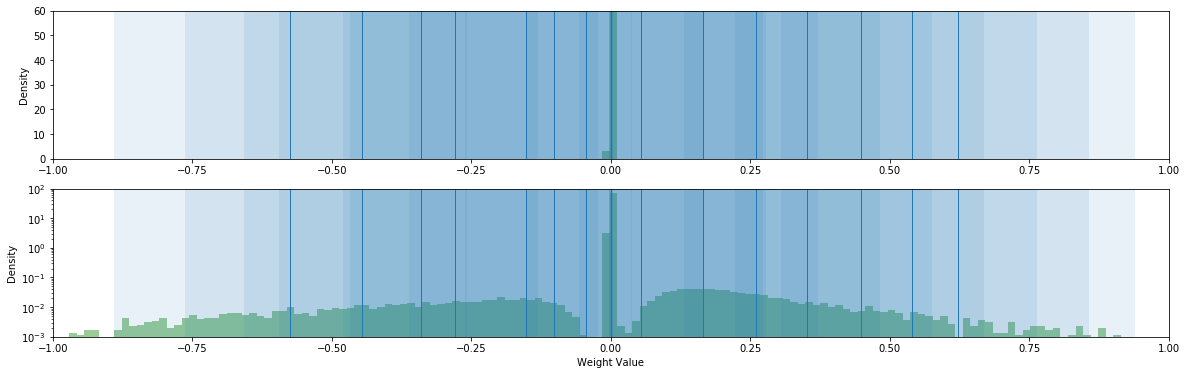

In [8]:
show_sws_weights(model = model_kd, means = list(gmp_kd.means.data.clone().cpu()), precisions = list(gmp_kd.gammas.data.clone().cpu()))

### KD with Scaling

In [ ]:
model_kd_s, gmp_kd_s = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", True)

In [ ]:
show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))

### KD with Separate Layer Priors